# Investigating the KNN algorithm as an alternative classifier

In [1]:
import torch
import pandas as pd
import os
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import Dataset

bean_annotations = pd.read_csv("data/beans.csv")
bean_annotations.head()
DEFECT_CLASSES = dict(
    [
        (defect, index)
        for (index, defect) in enumerate(pd.unique(bean_annotations["defect_class"]))
    ]
)


transform = v2.Compose(
    [
        v2.Resize(size=(400, 400)),
        v2.ToDtype(
            torch.float32, scale=True
        ),  # Use float32 datatype to enable training on Apple silicon GPU
        # v2.Grayscale(),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [2]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bean_annotations)

    def get_labels(self):
        return self.bean_annotations["defect_class"]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        annotations = DEFECT_CLASSES[
            self.bean_annotations.iloc[item, 1:]["defect_class"]
        ]
        return image, annotations

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    bean_annotations,
    test_size=0.2,
    random_state=42,  # for repeatability
    stratify=bean_annotations["defect_class"],
)

In [4]:
from torch.utils.data import DataLoader, SubsetRandomSampler

dataset = RoastDefectsDataset(
    csv_file="data/beans.csv",
    root_dir="data/processed-whitebg",
    transform=transform,
)

train_sampler = SubsetRandomSampler(list(train.index))
test_sampler = SubsetRandomSampler(list(test.index))


train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=len(train))
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=len(test))

dataloaders = {"test": test_loader, "train": train_loader}
dataset_sizes = {"test": len(test), "train": len(train)}

## Build datasets

In [5]:
X_train = []
y_train = []
X_test = []
y_test = []
for _, (data, label) in enumerate(train_loader):
    X_train = data.squeeze()
    y_train = label.squeeze()

for _, (data, label) in enumerate(test_loader):
    X_test = data.squeeze()
    y_test = label.squeeze()

## Dimensionality reduction attempt 1 - color histograms

In [39]:
from skimage.exposure import histogram

X_train_hists = [histogram(img.numpy(), nbins=32)[0] for img in X_train]
X_test_hists = [histogram(img.numpy(), nbins=32)[0] for img in X_test]

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

for k in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=k, metric="canberra")
    knn.fit(X_train_hists, y_train)
    preds = knn.predict(X_test_hists)

    print(
        "K = ",
        k,
        "accuracy: ",
        classification_report(
            y_test,
            preds,
            zero_division=0,
            target_names=DEFECT_CLASSES.keys(),
            output_dict=True,
        )["accuracy"],
    )

    # print(classification_report(y_test, preds, zero_division=0, target_names=DEFECT_CLASSES.keys()))

K =  1 accuracy:  0.7060931899641577
K =  2 accuracy:  0.6612903225806451
K =  3 accuracy:  0.7329749103942652
K =  4 accuracy:  0.7347670250896058
K =  5 accuracy:  0.7383512544802867
K =  6 accuracy:  0.7437275985663082
K =  7 accuracy:  0.7491039426523297
K =  8 accuracy:  0.7419354838709677
K =  9 accuracy:  0.7437275985663082
K =  10 accuracy:  0.7419354838709677
K =  11 accuracy:  0.7347670250896058
K =  12 accuracy:  0.7347670250896058
K =  13 accuracy:  0.7329749103942652
K =  14 accuracy:  0.7329749103942652
K =  15 accuracy:  0.7258064516129032
K =  16 accuracy:  0.7293906810035843
K =  17 accuracy:  0.7275985663082437
K =  18 accuracy:  0.7258064516129032
K =  19 accuracy:  0.7240143369175627
K =  20 accuracy:  0.7329749103942652
K =  21 accuracy:  0.7222222222222222
K =  22 accuracy:  0.7329749103942652
K =  23 accuracy:  0.7293906810035843
K =  24 accuracy:  0.7311827956989247
K =  25 accuracy:  0.7275985663082437
K =  26 accuracy:  0.7311827956989247
K =  27 accuracy:  0.

              precision    recall  f1-score   support

       burnt      0.000     0.000     0.000        10
      normal      0.772     0.951     0.852       263
        frag      0.818     0.153     0.257        59
       under      1.000     0.048     0.091        21
      quaker      0.730     0.827     0.775       196
insectOrMold      0.000     0.000     0.000         9

    accuracy                          0.756       558
   macro avg      0.553     0.330     0.329       558
weighted avg      0.744     0.756     0.704       558


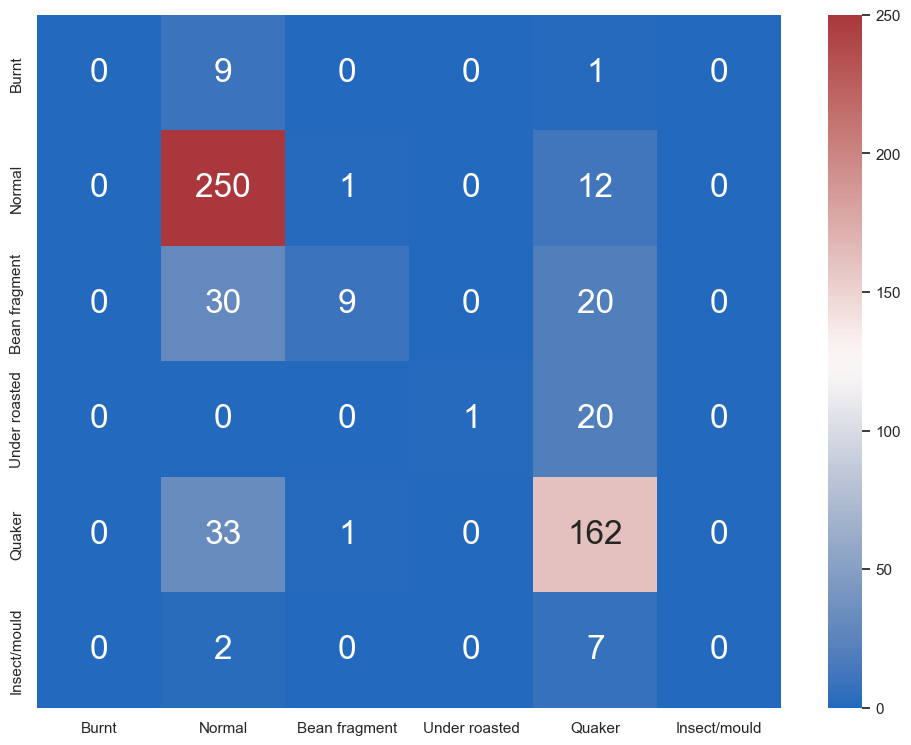

In [53]:
from torcheval.metrics import MulticlassConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt

DEFECT_CLASSES_PRINT_NAMES = {
    "burnt": "Burnt",
    "normal": "Normal",
    "frag": "Bean fragment",
    "under": "Under roasted",
    "quaker": "Quaker",
    "insectOrMold": "Insect/mould",
}

knn = KNeighborsClassifier(n_neighbors=28, metric="manhattan")
knn.fit(X_train_hists, y_train)
preds = knn.predict(X_test_hists)
print(
    classification_report(
        y_test, preds, zero_division=0, target_names=DEFECT_CLASSES.keys(), digits=3
    )
)

matrix = MulticlassConfusionMatrix(len(DEFECT_CLASSES))
matrix.update(torch.tensor(preds), y_test)

confs = matrix.compute()


fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    confs,
    annot=True,  # write values in cells
    cmap="vlag",
    xticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    yticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    ax=ax,
    fmt="g",  # annotate without using scientific notation
    annot_kws={"fontsize": 24},
)
plt.savefig("report/figures/results/KNN-1.png")